---
# Size-response experiment

In [1]:
from IPython.display import Image

This notebook contains an initial analysis of 1 run (`/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-3_bold.mat`) of the Size-Response experiment executed on `01/02/2022`.

In this experiment, we tune the stimulus based on the obtained parameters earlier: after fitting an `iterative` fit to our `ses-1`-pRF data, we select a best vertex using `call_targetvertex`, which is embedded in `spinoza_bestvertex` that can be called easily with `master -m 18 -s <subject>`. This outputs a `model-gauss_desc-best_vertices.csv`-file in `derivatives/pycortex/<subject>`. We then do `call_sizeresponse -s <subject>`, which takes this file, applies a divise normalization (DN-) model with `iterative fit`. Internally, it assumes that the obtained pRF size is the `average across layers`. Alessio showed earlier that the pRF-size is `smaller` in the `middle` layers, so `call_sizeresponse` creates a size-response (SR-) curve for a superficial/deep pRF (defined as the pRF-size obtained with gaussian fit) and for a middle layer pRF (defined as 80% of the superficial/deep pRF size). Then, it looks for stimulus sizes where the differences between these curves are maximal, the peaks of both curves, and the intersection of the curves to obtain ~5 stimulus sizes. These stimulus sizes are then saved in a `.npy`-file in `derivatives/pycortex/<subject>` that is read in by the `sizeresponse`-experiment. 

NOTE: because the BOLD-screen was recently moved closer to the bore, we had to adapt our stimulus location/size accordingly. Below the calculation:

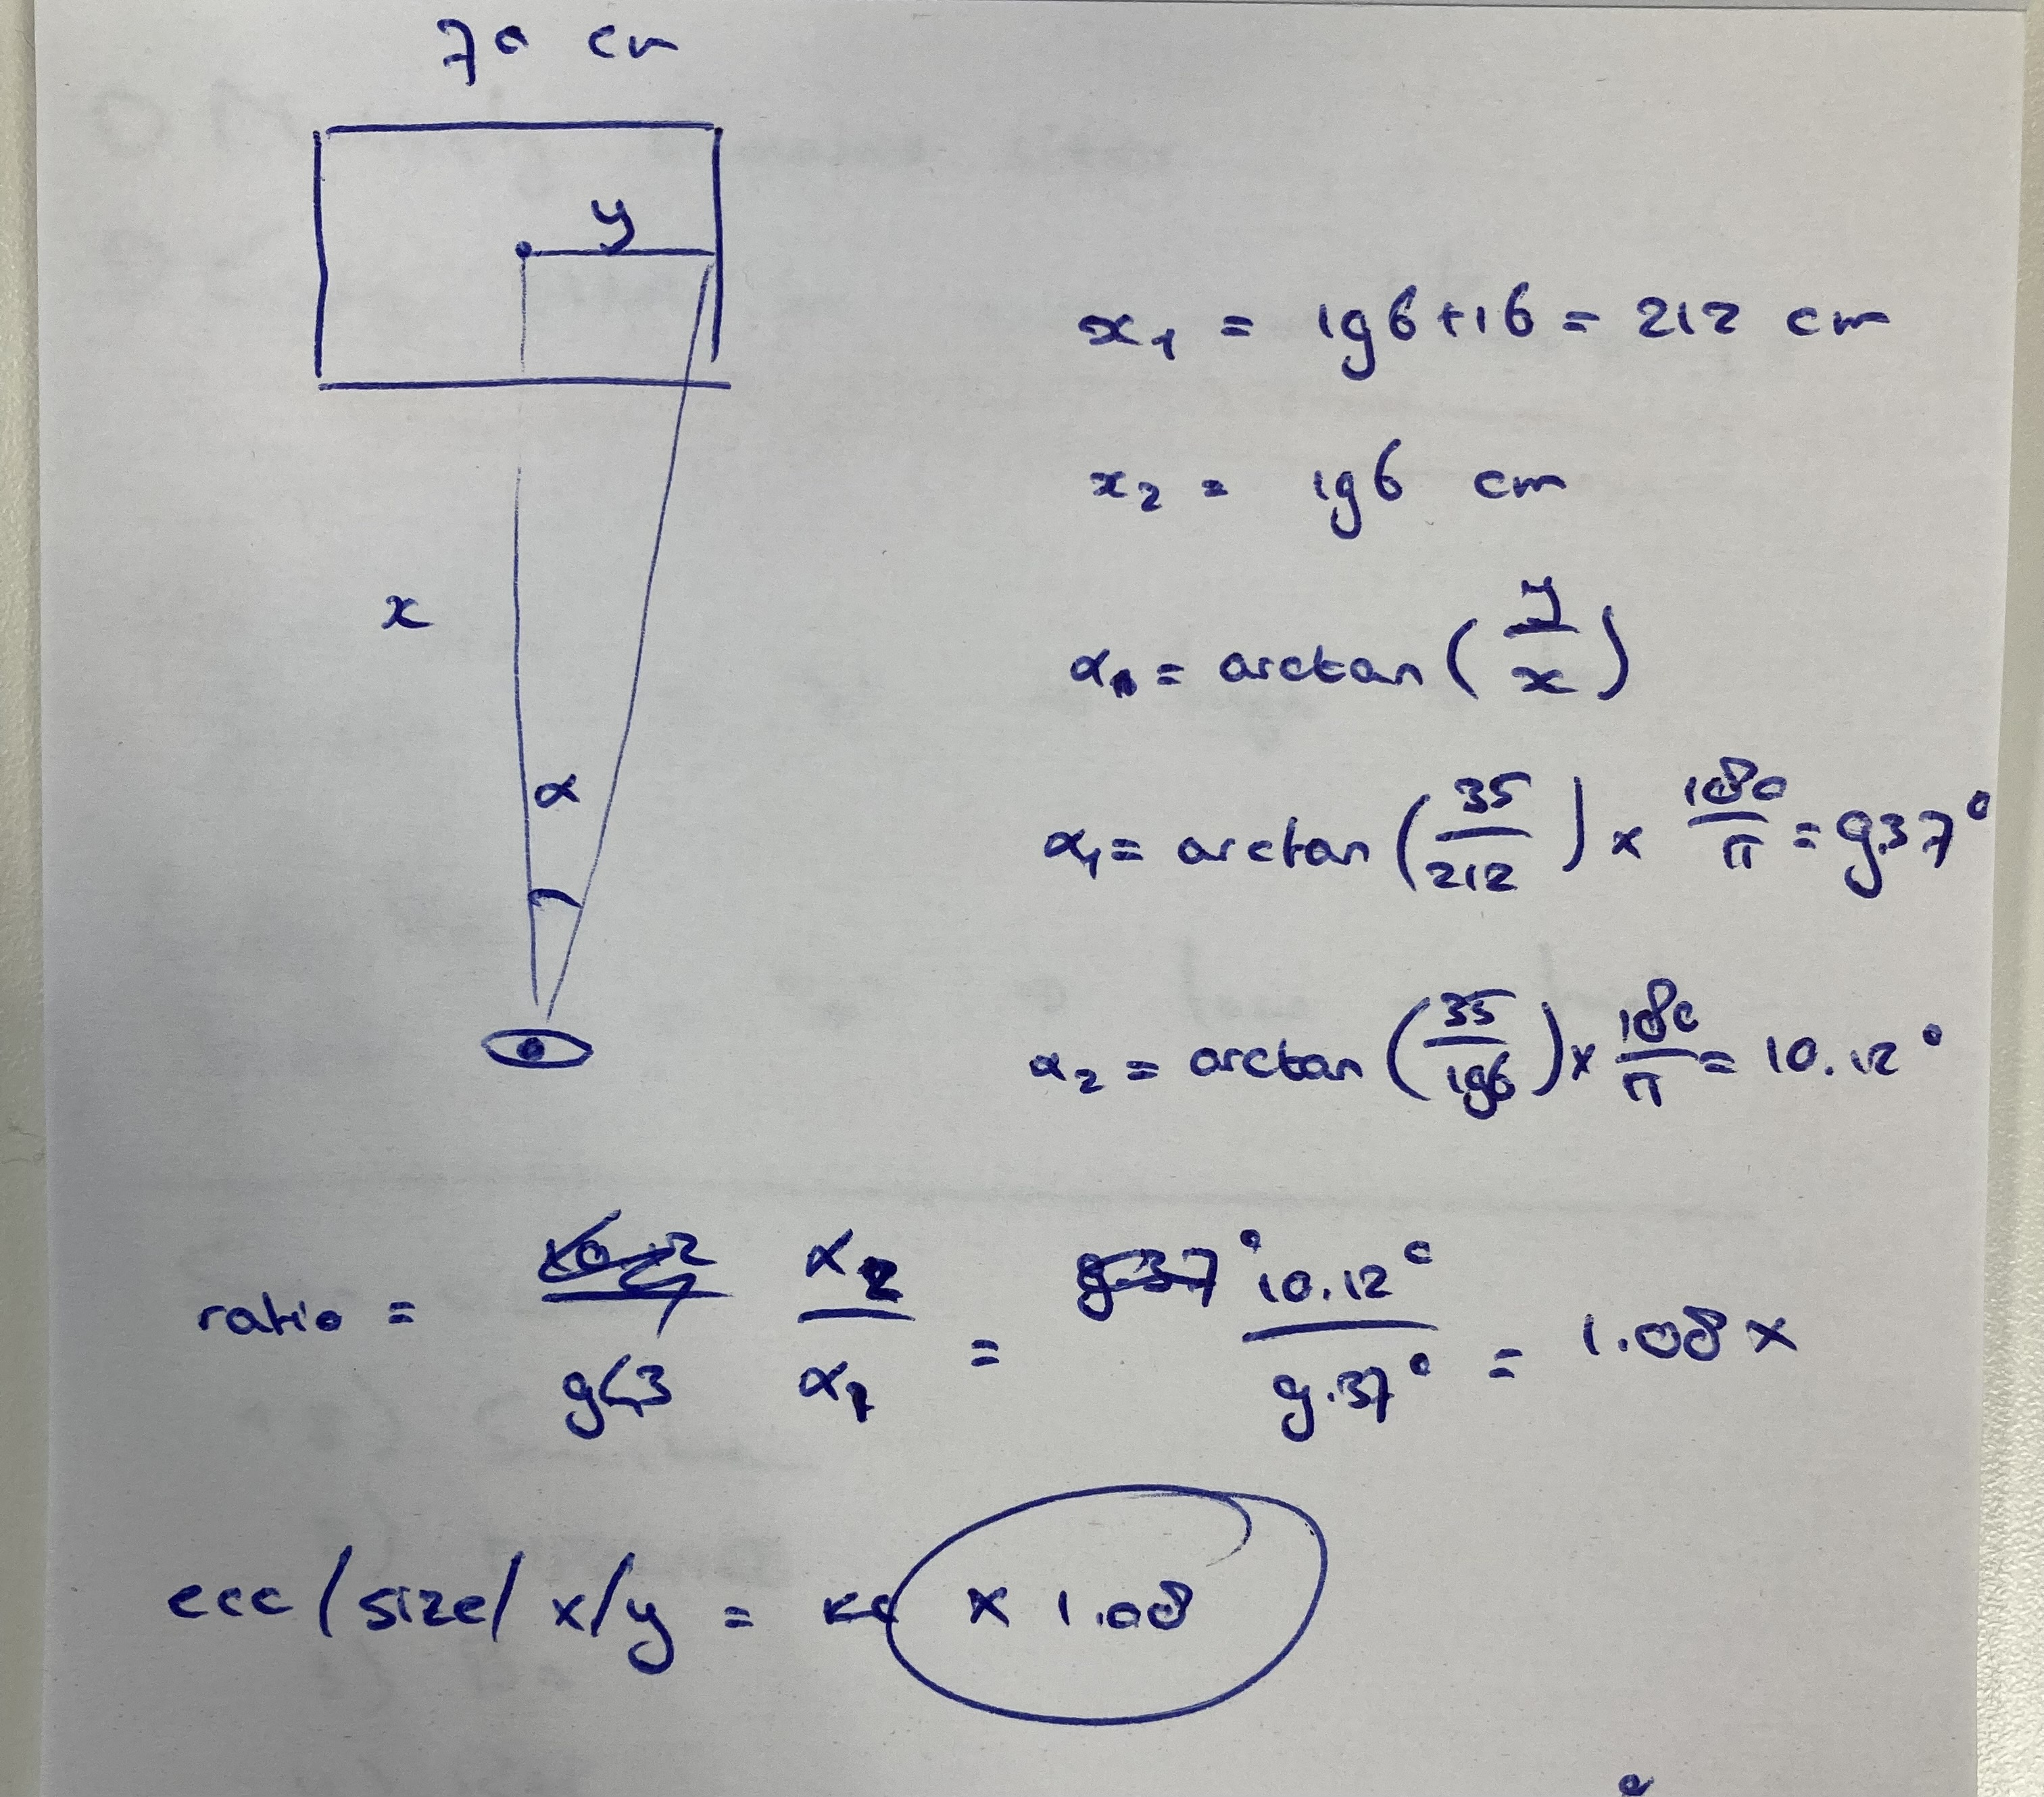

In [2]:
Image(filename="../imgs/boldscreen_increase_ratio.jpg")

This calculation shows that the x/y-location, eccentricity, and size are increased by a factor of `1.08` with the new BOLD-screen location. Therefore, the stimulus sizes and pRF-location have been updated **AFTER** running `call_sizeresponse`, so after fitting the DN-model with iterative fit.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from linescanning import utils,prf,glm,dataset,plotting
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import nideconv as nd
from scipy.stats import sem
import os
import pandas as pd
opj = os.path.join

warnings.simplefilter('ignore')
project_dir     = os.environ.get("DIR_PROJECTS")
base_dir        = opj(project_dir, 'hemifield')
deriv_dir       = opj(base_dir, 'derivatives')

plot_vox = 359
plot_xkcd = True

/home/gjheij/anaconda3/envs/mpl/lib/python3.10/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/home/gjheij/anaconda3/envs/mpl/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


Fetch the files representing the functional data (`bold.mat` > `call_linerecon`), experiment log file `events.tsv` > `exptools2`), regressor file (`physio.txt`) and mat-file (`physio.mat`) physio files (`call_spmphysio`). `run_files` collects all these files in a list, from which we can then pick the required files and store them in their respective variable

In [53]:
# Load data
sub         = '003'
ses         = 3
task        = "task-SR"
runs        = [3,4,6]
func_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "func")
anat_dir    = opj(os.path.dirname(func_dir), 'anat')
ribbon      = (356,363)

run_files   = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}"], func_dir)
func_file   = utils.get_file_from_substring("bold.mat", run_files)
exp_file    = utils.get_file_from_substring("events.tsv", run_files)
anat_slices = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", "acq-1slice", ".nii.gz"], anat_dir)
ref_slices  = utils.match_lists_on(func_file, anat_slices, matcher='run')
ref_slices


['/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/anat/sub-003_ses-3_acq-1slice_run-3_T1w.nii.gz',
 '/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/anat/sub-003_ses-3_acq-1slice_run-4_T1w.nii.gz',
 '/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/anat/sub-003_ses-3_acq-1slice_run-6_T1w.nii.gz']

DATASET

FUNCTIONAL
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-3_bold.mat
 Filtering strategy: 'hp'
 Cutting 50 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
 Source dir: /mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/nighres/sub-003/ses-1
 Target session: ses-3
 Foldover: FH
 Ref slice: /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/anat/sub-003_ses-3_acq-1slice_run-3_T1w.nii.gz
 Found 61 voxels for nuisance regression
 We're good to go!
 Using 5 components for aCompCor (WM/CSF separately)
 Found 2 component(s) in 'csf'-voxels with total explained variance of 0.41%
 Found 1 component(s) in 'wm'-voxels with total explained variance of 0.48%
 DCT high-pass filter on components [removes low frequencies <0.2 Hz]
 Saving /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/anat/sub-003_ses-3_run-3-desc_acompcor.png
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemif

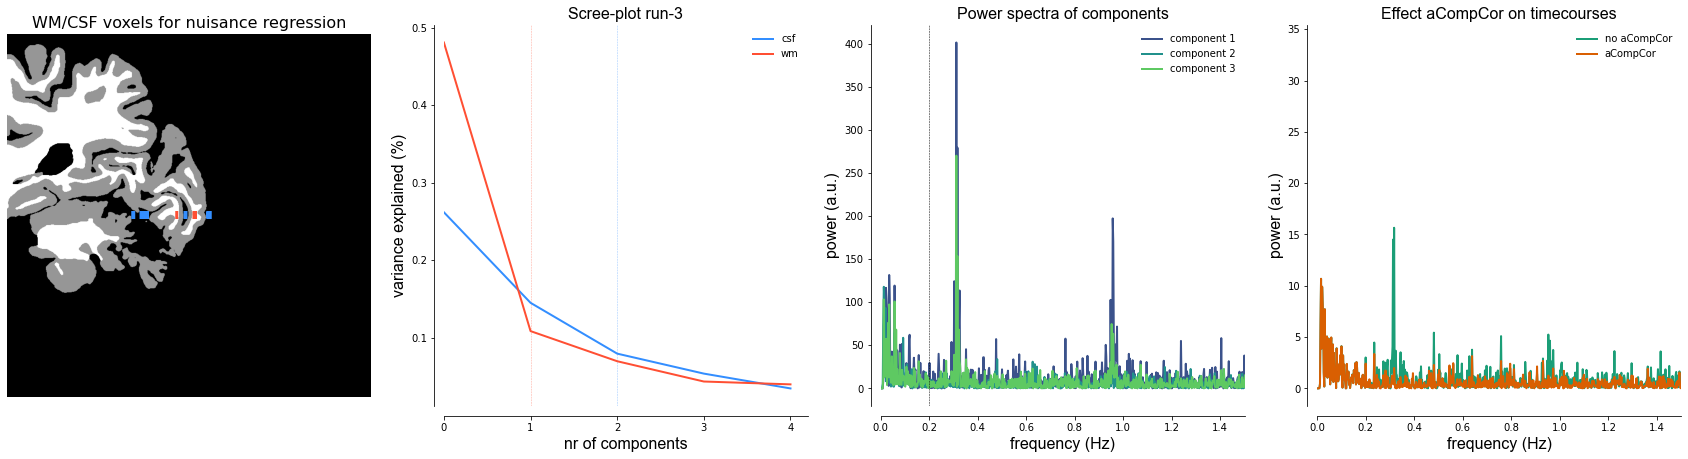

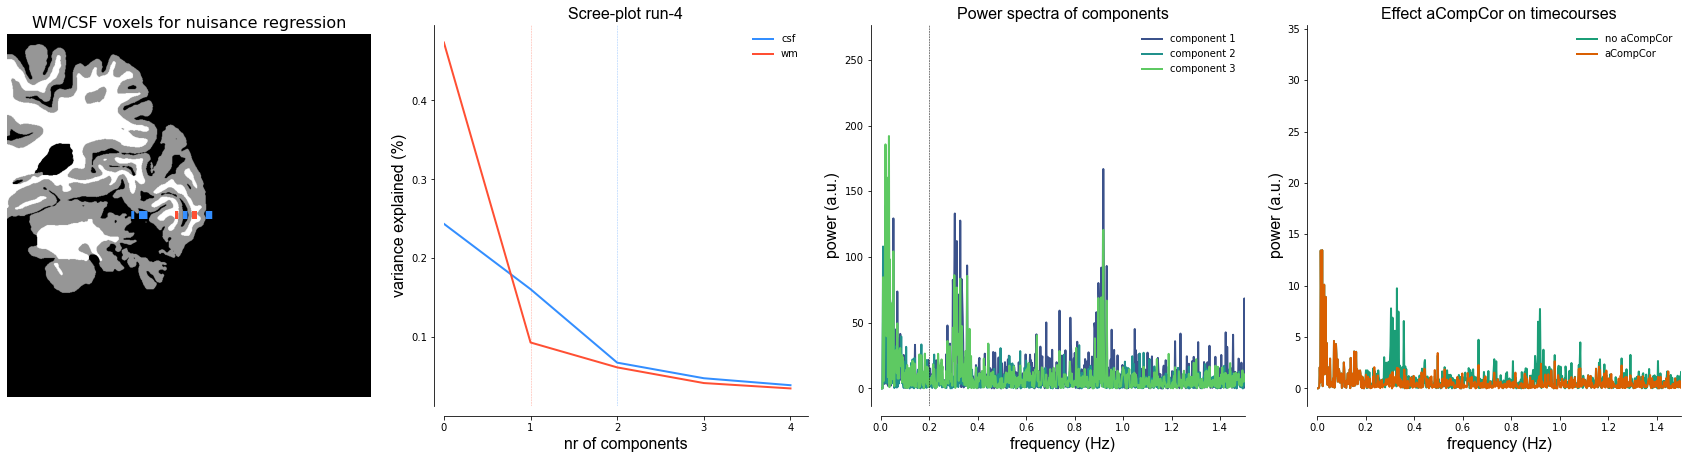

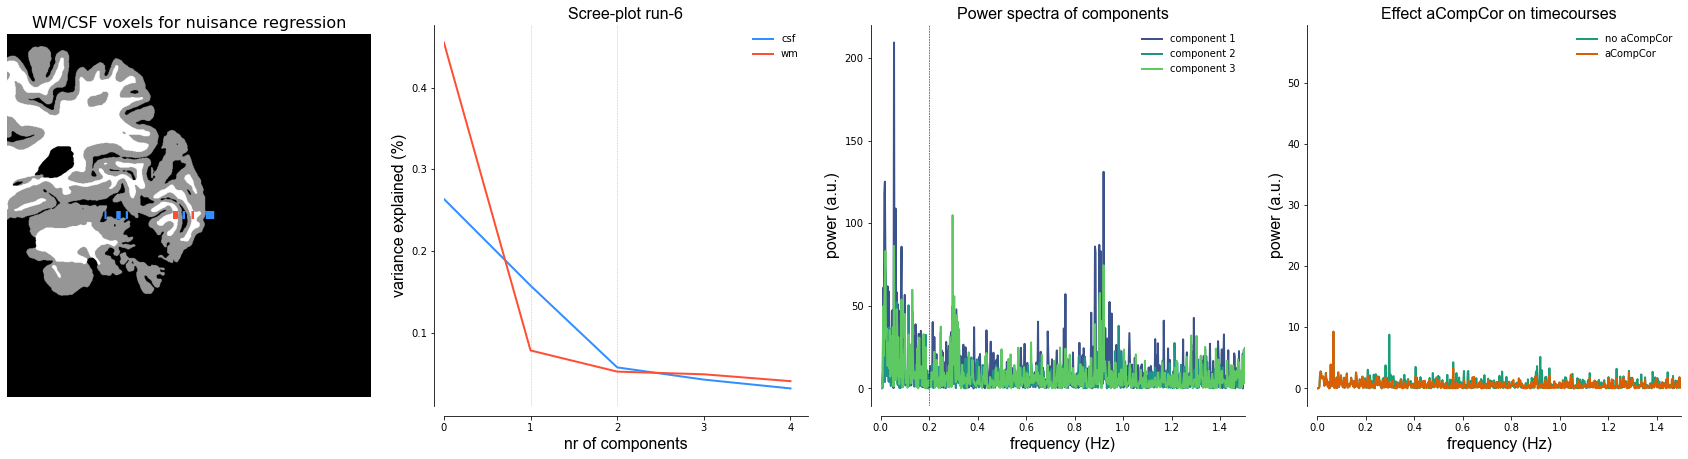

In [91]:
window = 19
order = 3

# mind you, the segmentations live in ses-1 space, NOT FREESURFER!
ses_to_motion = utils.get_file_from_substring(f"ses{ses}_rec-motion1", opj(deriv_dir, 'pycortex', f"sub-{sub}", 'transforms'))
run2run = utils.get_file_from_substring(['.txt'], anat_dir)


# data_obj = dataset.Dataset(func_file,
#                            deleted_first_timepoints=50, 
#                            deleted_last_timepoints=50,
#                            window_size=window, # needs to be odd
#                            high_pass=True,
#                            tsv_file=exp_file,
#                            poly_order=order,
#                            use_bids=True,
#                            verbose=True)

data_obj = dataset.Dataset(func_file,
                           tsv_file=exp_file,
                           deleted_first_timepoints=50, 
                           deleted_last_timepoints=50,
                           use_bids=True,
                           verbose=True,
                           acompcor=True,
                           ref_slice=ref_slices,
                           ses1_2_ls=ses_to_motion,
                           run_2_run=run2run,
                           n_pca=5,
                           save_as=opj(anat_dir, f"sub-{sub}_ses-{ses}_"))


In [37]:
data_obj.to_hdf(opj(func_dir, "sub-003_ses-3.h5"))

Saving to /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3.h5
 Saving attribute: df_func_psc
 Saving attribute: df_func_raw
 Saving attribute: df_onsets
Done


In [38]:
data_obj2 = dataset.Dataset(opj(func_dir, "sub-003_ses-3.h5"), verbose=True)


DATASET
 Reading from /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3.h5
 Setting attribute: df_func_psc
 Setting attribute: df_func_raw
 Setting attribute: df_onsets

DATASET: created


In [39]:
df_func     = data_obj2.fetch_fmri()
df_onsets   = data_obj2.fetch_onsets()
df_onsets


Fetching dataframe from attribute 'df_func_psc'


onset
subject run event_type                   
003     3   2.014613132977678   24.363776
            3.5652478065289     26.655493
            3.5652478065289     35.213706
            2.13914868391734    36.855363
            2.13914868391734    39.913720
...                                   ...
        6   1.140879298089248  382.953138
            2.13914868391734   385.328232
            2.13914868391734   387.653167
            2.014613132977678  394.244731
            2.014613132977678  395.731014

[229 rows x 1 columns]

In [48]:
df_func     = data_obj.fetch_fmri()
df_onsets   = data_obj.fetch_onsets()
df_onsets

Fetching dataframe from attribute 'df_func_zscore'


onset
subject run event_type                   
003     3   2.014613132977678   24.363776
            3.5652478065289     26.655493
            3.5652478065289     35.213706
            2.13914868391734    36.855363
            2.13914868391734    39.913720
...                                   ...
        6   1.140879298089248  382.953138
            2.13914868391734   385.328232
            2.13914868391734   387.653167
            2.014613132977678  394.244731
            2.014613132977678  395.731014

[229 rows x 1 columns]

As a side note, we can select individual runs using `utils.select_from_df`. I wrote this function because it can be quite a hassle to select particular sections from a `pandas.DataFrame`

In [73]:
run1_func = utils.select_from_df(df_func, expression=(f"run = {runs[2]}"))
run1_func

vox 0     vox 1     vox 2     vox 3     vox 4  \
subject run t                                                           
003     6   0.000   -0.250566  0.753429  0.519340  0.263463 -0.704060   
            0.105   -0.227720 -0.285831 -2.427786 -1.121507 -0.947576   
            0.210    1.194443  1.011433  0.382705  1.085981  0.301966   
            0.315    1.889553 -1.414432 -0.440912 -0.055631 -0.283798   
            0.420   -0.851777 -0.184692  1.865142 -0.651588  0.528289   
...                       ...       ...       ...       ...       ...   
            450.975 -2.014067 -0.489167 -0.649320  0.380227 -0.397761   
            451.080  0.626261  2.382499  0.122380 -0.914707  0.812847   
            451.185 -0.984342 -2.413565  0.222727 -2.180391 -1.000012   
            451.290 -0.374131 -0.489473 -1.550929 -0.483352 -1.246051   
            451.395 -0.367418 -0.081203  1.857801  1.166570 -0.125756   

                        vox 5     vox 6     vox 7     vox 8     vox 9  ...  \
subject run t                                                          ...   
003     6   0.000   -1.332242 -0.185190 -0.238663  0.434545  2.097782  ...   
            0.105   -0.776297  0.669077 -0.770620 -2.282580 -0.460508  ...   
            0.210   -0.730625  0.188000  1.139671  1.490947  1.961219  ...   
            0.315    1.319299  0.715756  0.529355  0.800623  2.276062  ...   
            0.420   -1.488160 -0.749329 -0.884677  0.669458  0.584120  ...   
...                       ...       ...       ...       ...       ...  ...   
            450.975  0.217052  0.752013 -1.063211  1.612060 -0.506530  ...   
            451.080  0.274636 -0.191616  0.641896  1.096059  1.230520  ...   
            451.185 -0.701025 -0.474466 -2.420828  0.283078 -1.624762  ...   
            451.290 -0.585567  0.114843 -0.315463 -1.233216 -1.338819  ...   
            451.395  1.084260  0.234191 -0.985953  0.422391 -0.696790  ...   

                      vox 710   vox 711   vox 712   vox 713   vox 714  \
subject run t                                                           
003     6   0.000    0.060813 -0.273088 -0.221474  0.260450  0.055593   
            0.105    1.062886  0.121631 -1.118377 -0.255571 -0.048240   
            0.210    1.075453 -0.568281 -0.491484  0.605265  2.263450   
            0.315   -0.549663 -0.027327 -0.431551  1.856949  1.147252   
            0.420   -0.789406  1.531330 -1.226221 -1.386684  0.395271   
...                       ...       ...       ...       ...       ...   
            450.975 -0.897255 -0.112606  0.051606  0.164251  0.005465   
            451.080 -0.871112 -0.175426  0.581553 -0.570081  0.249490   
            451.185 -1.233242 -0.476248  1.049303  0.779358 -0.154857   
            451.290 -0.791572 -0.865613 -0.486102  1.694597  0.944585   
            451.395  0.622056  0.549390 -0.341443  1.418379 -0.655914   

                      vox 715   vox 716   vox 717   vox 718   vox 719  
subject run t                                                          
003     6   0.000   -0.298452  0.026666 -0.427438  0.210579 -1.350557  
            0.105    0.286810  0.714900  0.642691 -0.508423  1.168160  
            0.210    0.077813  1.019385 -0.068662 -1.365033  0.710454  
            0.315   -1.568467  0.398716 -1.250596  0.003921 -0.559995  
            0.420    1.314376  0.572588  0.092010  0.914324  0.799403  
...                       ...       ...       ...       ...       ...  
            450.975  0.210078  2.154196  0.271808  0.237644  0.427346  
            451.080  0.651382  2.256447 -1.710075 -0.655600 -0.335653  
            451.185  0.001390 -1.083050 -0.454685 -0.767228  0.365960  
            451.290 -0.340589  1.346190 -0.319736 -1.360866  1.096067  
            451.395  0.228646 -0.957544 -2.084392  0.679522 -0.445044  

[4300 rows x 720 columns]

In [50]:
run1_onsets = utils.select_from_df(df_onsets, expression=(f"run = {runs[0]}"))
run1_onsets

onset
subject run event_type                   
003     3   2.014613132977678   24.363776
            3.5652478065289     26.655493
            3.5652478065289     35.213706
            2.13914868391734    36.855363
            2.13914868391734    39.913720
...                                   ...
            2.13914868391734   372.703811
            2.13914868391734   376.503695
            2.13914868391734   386.603704
            2.13914868391734   388.230752
            2.13914868391734   392.345201

[78 rows x 1 columns]

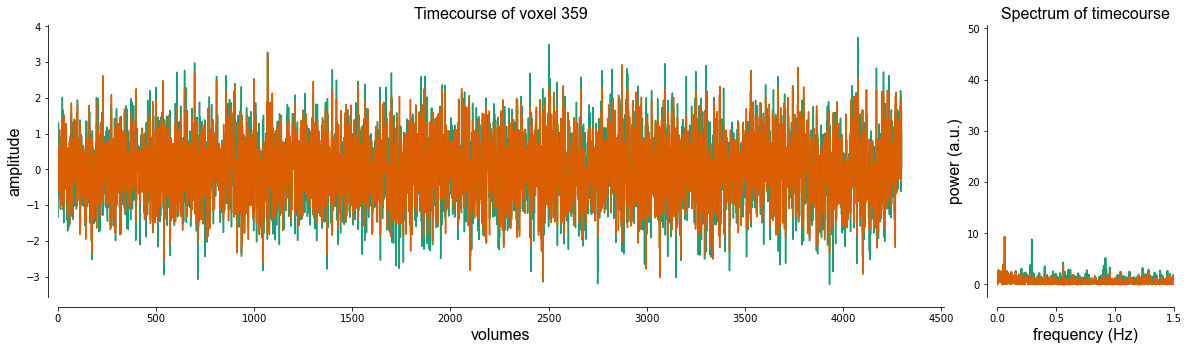

In [81]:
colors = ["#1B9E77", "#D95F02"]
freq_type = "fft"
clipper = 100
tc1 = data_obj.hp_zscore_df['vox 359'].values
tc2 = run1_func['vox 359'].values

fig = plt.figure(figsize=(20, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[10, 2], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
plotting.LazyPlot([tc1, tc2],
                  color=colors,
                  x_label="volumes",
                  y_label="amplitude",
                  title="Timecourse of voxel 359",
                  axs=ax1,
                  font_size=16,
                  line_width=1.5)

ax2 = fig.add_subplot(gs[1])
tc1_freq = data_obj.get_freq(tc1, TR=0.105, spectrum_type=freq_type, clip_power=clipper)
tc2_freq = data_obj.get_freq(tc2, TR=0.105, spectrum_type=freq_type, clip_power=clipper)

plotting.LazyPlot([tc1_freq[1], tc2_freq[1]],
                  xx=tc1_freq[0],
                  color=colors,
                  x_label="frequency (Hz)",
                  y_label="power (a.u.)",
                  title="Spectrum of timecourse",
                  axs=ax2,
                  xkcd=False,
                  font_size=16,
                  x_lim=[0, 1.5],
                  line_width=2)


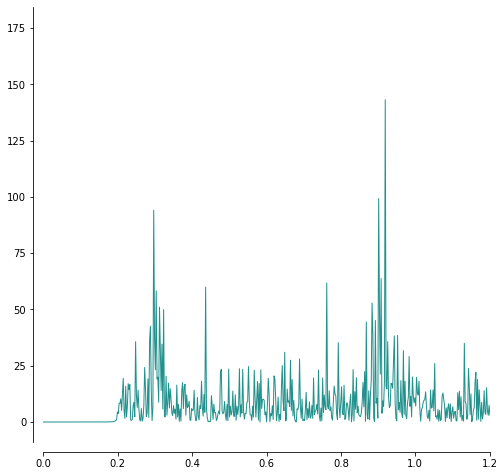

In [80]:
freq_, power_ = data_obj.get_freq(data_obj.confs[:,0], TR=data_obj.TR, spectrum_type="fft")
plotting.LazyPlot(power_, freq_, figsize=(8,8), x_lim=[0,1.2])

In [17]:
# utils.LazyPlot(physio_df['hr'].values, 
#                figsize=(30,5),
#                x_label="volumes",
#                y_label="heart rate (BPM)",
#                title=f"Heart rate",
#                add_hline={'pos': physio_df['hr'].values.mean(), 'ls': '--', 'color': 'k', 'lw': 0.5},
#                set_xlim_zero=True,
#                sns_trim=False,
#                font_size=18)

# print(f"Mean heart rate = {round(physio_df['hr'].values.mean(),2)}")

---
# Generic GLM

## Only Glover HRF

In [12]:
fitters     = []
dispersion  = False
derivatives = False

# change this depending on the derivatives used
tstats = np.zeros((6,720,3))
    
for run in range(3):
    data = utils.select_from_df(df_func, expression=(f"run = {runs[run]}"))
    onsets = utils.select_from_df(df_onsets, expression=(f"run = {runs[run]}"))

    fitting = glm.GenericGLM(onsets, data.values, TR=data_obj.TR, osf=1000, derivative=derivatives, dispersion=dispersion, verbose=False)
    fitters.append(fitting)

    tstats[...,run] = fitting.results['tstats']

# calculate average tstats
avg_runs = tstats.mean(axis=-1)
print(avg_runs.shape)

# cut away intercept
avg_tstats_glover = [avg_runs[ii+1,...] for ii in range(avg_runs.shape[0]-1)]

max tstat (vox 609) = 6.38
max beta (vox 609) = 2.44
max tstat (vox 540) = 13.15
max beta (vox 540) = 4.7
max tstat (vox 627) = 7.37
max beta (vox 627) = 2.83
(6, 720)


Plot the t-stats across the line for each stimulus event (size) and zoom in on the relevant portion

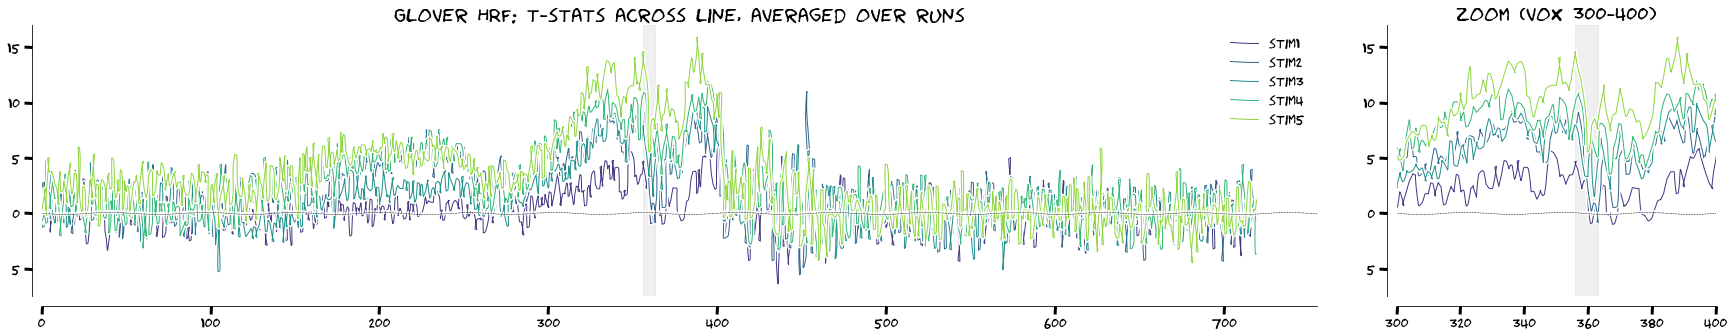

In [13]:
fig = plt.figure(figsize=(30,5))
gs = fig.add_gridspec(1,2, width_ratios=[4,1], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
ax1.axvspan(*ribbon, alpha=0.3, color="#cccccc")
plotting.LazyPlot(avg_tstats_glover,
                  axs=ax1, 
                  add_hline='default', 
                  set_xlim_zero=True, 
                  sns_trim=False, 
                  title="Glover HRF: t-stats across line, averaged over runs", 
                  font_size=20, 
                  xkcd=plot_xkcd,
                  labels=[f"stim{ii+1}" for ii in range(len(fitting.condition_names))])

ax2 = fig.add_subplot(gs[1])
ax2.axvspan(*ribbon, alpha=0.3, color="#cccccc")
plotting.LazyPlot(avg_tstats_glover,
                  axs=ax2, 
                  add_hline='default', 
                  set_xlim_zero=False, 
                  sns_trim=False, 
                  title="zoom (vox 300-400)", 
                  font_size=20, 
                  x_lim=[300,400],
                  xkcd=plot_xkcd)              

Plot the t-stats for each stimulus event across runs

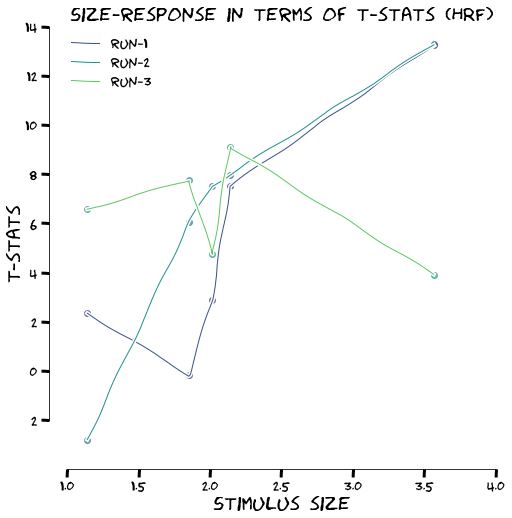

In [14]:
fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(1,1)

x = [float(ii) for ii in fitting.condition_names]
color_list = sns.color_palette('viridis', len(x))

# plot the main HRF
for idx,hrf in enumerate(['HRF']):

    ax1 = fig.add_subplot(gs[idx])

    if hrf == "HRF":
        sr_run = tstats[1:,ribbon[0]:ribbon[1],...].mean(axis=1)

    sr_ = [sr_run[...,ii] for ii in range(sr_run.shape[-1])]
    for ix, mark in enumerate(sr_):
        ax1.plot(x, mark, 'o', color=color_list[ix], alpha=0.6)

    plotting.LazyPlot(sr_,
                    xx=x,
                    axs=ax1, 
                    title=f"Size-response in terms of t-stats ({hrf})", 
                    font_size=20,
                    x_label="Stimulus size",
                    y_label="t-stats",
                    xkcd=plot_xkcd,
                    x_lim=[x[0]-0.2,x[-1]+0.5],
                    sns_trim=True,
                    labels=[f"run-{ii+1}" for ii in range(len(sr_run))])


## Glover + time derivative

In [15]:
fitters     = []
dispersion  = False
derivatives = True

# change this depending on the derivatives used
tstats = np.zeros((11,720,3))
    
for run in range(3):
    data = utils.select_from_df(df_func, expression=(f"run = {runs[run]}"))
    onsets = utils.select_from_df(df_onsets, expression=(f"run = {runs[run]}"))

    fitting = glm.GenericGLM(onsets, data.values, TR=data_obj.TR, osf=1000, derivative=derivatives, dispersion=dispersion, verbose=False)
    fitters.append(fitting)

    tstats[...,run] = fitting.results['tstats']

# calculate average tstats
avg_runs = tstats.mean(axis=-1)
print(avg_runs.shape)

# cut away intercept
avg_tstats_glover_td = [avg_runs[ii+1,...] for ii in range(avg_runs.shape[0]-1)]

max tstat (vox 704) = 7.17
max beta (vox 704) = 3.11
max tstat (vox 672) = 8.61
max beta (vox 672) = 3.7
max tstat (vox 481) = 7.13
max beta (vox 481) = 3.09
(11, 720)


Plot the t-stats across the line for each stimulus event (size) and zoom in on the relevant portion

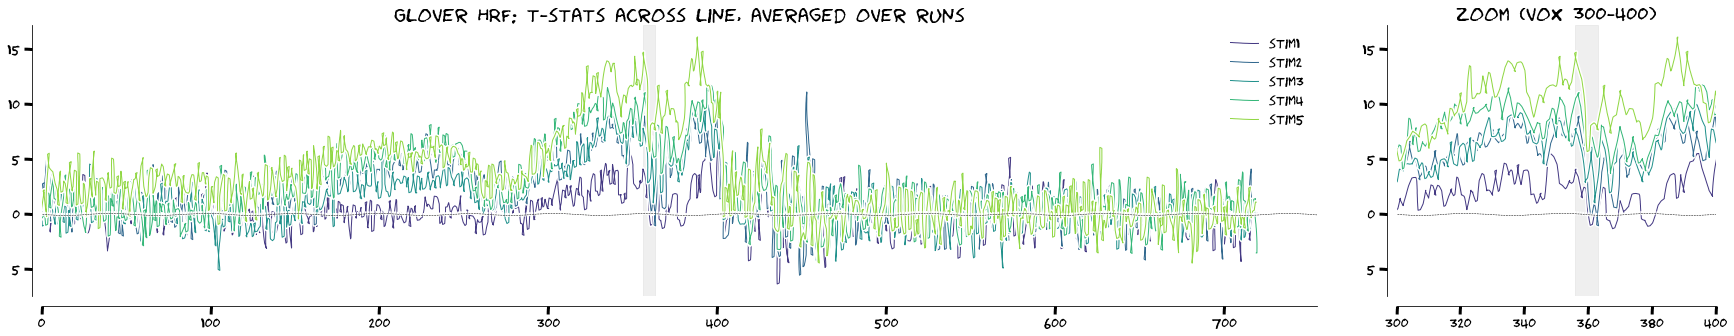

In [16]:
fig = plt.figure(figsize=(30,5))
gs = fig.add_gridspec(1,2, width_ratios=[4,1], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
ax1.axvspan(*ribbon, alpha=0.3, color="#cccccc")
plotting.LazyPlot(avg_tstats_glover_td[0::2],
                  axs=ax1, 
                  add_hline='default', 
                  set_xlim_zero=True, 
                  sns_trim=False, 
                  title="Glover HRF: t-stats across line, averaged over runs", 
                  font_size=20, 
                  xkcd=plot_xkcd,
                  labels=[f"stim{ii+1}" for ii in range(len(fitting.condition_names))])

ax2 = fig.add_subplot(gs[1])
ax2.axvspan(*ribbon, alpha=0.3, color="#cccccc")
plotting.LazyPlot(avg_tstats_glover_td[0::2],
                  axs=ax2, 
                  add_hline='default', 
                  set_xlim_zero=False, 
                  sns_trim=False, 
                  title="zoom (vox 300-400)", 
                  font_size=20, 
                  x_lim=[300,400],
                  xkcd=plot_xkcd)              

Plot, for each run, the tstats for the stimulus sizes, for the main HRF and it's time derivative

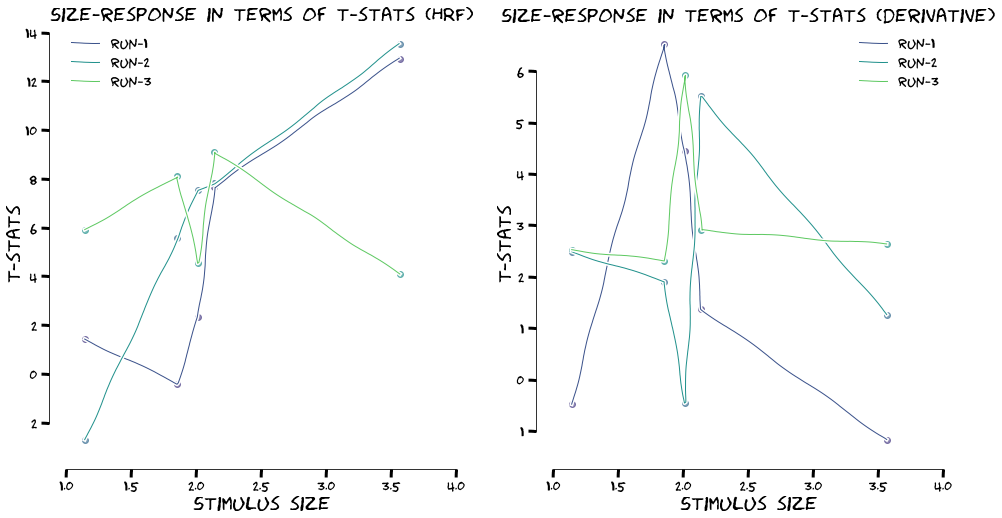

In [17]:
fig = plt.figure(figsize=(16,8))
gs = fig.add_gridspec(1,2)

x = [float(ii) for ii in fitting.condition_names]
color_list = sns.color_palette('viridis', len(x))

# plot the main HRF
for idx,hrf in enumerate(['HRF', 'derivative']):

    ax1 = fig.add_subplot(gs[idx])

    if hrf == "HRF":
        sr_run = tstats[1::2,ribbon[0]:ribbon[1],...].mean(axis=1)
    elif hrf == "derivative":
        sr_run = tstats[2::2,ribbon[0]:ribbon[1],...].mean(axis=1)

    sr_ = [sr_run[...,ii] for ii in range(sr_run.shape[-1])]
    for ix, mark in enumerate(sr_):
        ax1.plot(x, mark, 'o', color=color_list[ix], alpha=0.6)

    plotting.LazyPlot(sr_,
                    xx=x,
                    axs=ax1, 
                    title=f"Size-response in terms of t-stats ({hrf})", 
                    font_size=20,
                    x_label="Stimulus size",
                    y_label="t-stats",
                    xkcd=plot_xkcd,
                    x_lim=[x[0]-0.2,x[-1]+0.5],
                    sns_trim=True,
                    labels=[f"run-{ii+1}" for ii in range(len(sr_run))])


## Glover + derivative + dispersion

In [18]:
fitters = []
dispersion = True
derivatives = True

# change this depending on the derivatives used
tstats = np.zeros((16,720,3))
    
for run in range(3):
    data = utils.select_from_df(df_func, expression=(f"run = {runs[run]}"))
    onsets = utils.select_from_df(df_onsets, expression=(f"run = {runs[run]}"))

    fitting = glm.GenericGLM(onsets, data.values, TR=data_obj.TR, osf=1000, derivative=derivatives, dispersion=dispersion, verbose=False)
    fitters.append(fitting)

    tstats[...,run] = fitting.results['tstats']

# calculate average tstats
avg_runs = tstats.mean(axis=-1)
print(avg_runs.shape)

# cut away intercept
avg_tstats_glover_td_dd = [avg_runs[ii+1,...] for ii in range(avg_runs.shape[0]-1)]

max tstat (vox 661) = 8.95
max beta (vox 661) = 14.19
max tstat (vox 505) = 8.62
max beta (vox 505) = 15.78
max tstat (vox 626) = 6.64
max beta (vox 626) = 11.89
(16, 720)


Plot the t-stats across the line for each stimulus event (size) and zoom in on the relevant portion

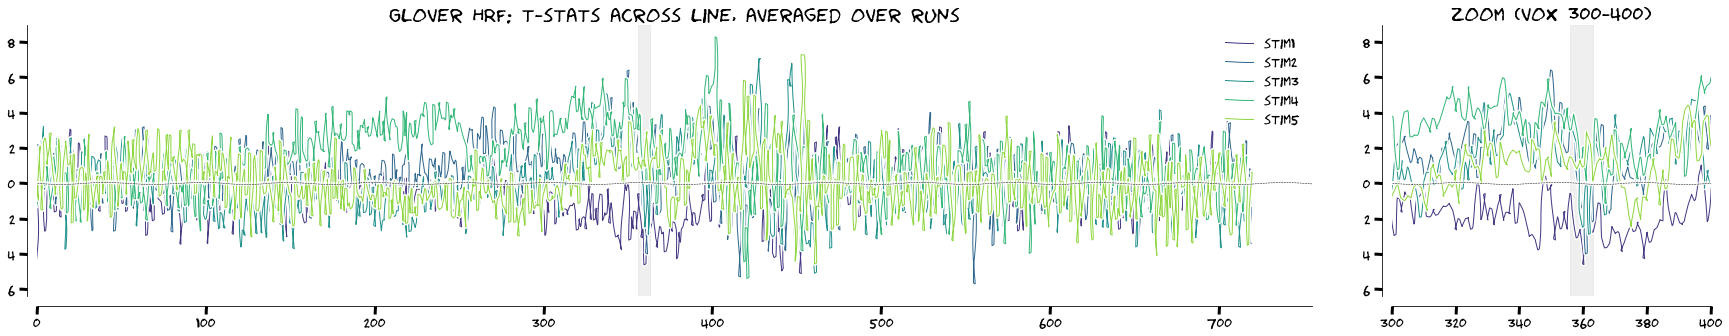

In [19]:
fig = plt.figure(figsize=(30,5))
gs = fig.add_gridspec(1,2, width_ratios=[4,1], wspace=0.1)

ax1 = fig.add_subplot(gs[0])
ax1.axvspan(*ribbon, alpha=0.3, color="#cccccc")
plotting.LazyPlot(avg_tstats_glover_td_dd[0::3],
                  axs=ax1, 
                  add_hline='default', 
                  set_xlim_zero=True, 
                  sns_trim=False, 
                  title="Glover HRF: t-stats across line, averaged over runs", 
                  font_size=20, 
                  xkcd=plot_xkcd,
                  labels=[f"stim{ii+1}" for ii in range(len(fitting.condition_names))])

ax2 = fig.add_subplot(gs[1])
ax2.axvspan(*ribbon, alpha=0.3, color="#cccccc")
plotting.LazyPlot(avg_tstats_glover_td_dd[0::3],
                  axs=ax2, 
                  add_hline='default', 
                  set_xlim_zero=False, 
                  sns_trim=False, 
                  title="zoom (vox 300-400)", 
                  font_size=20, 
                  x_lim=[300,400],
                  xkcd=plot_xkcd)              

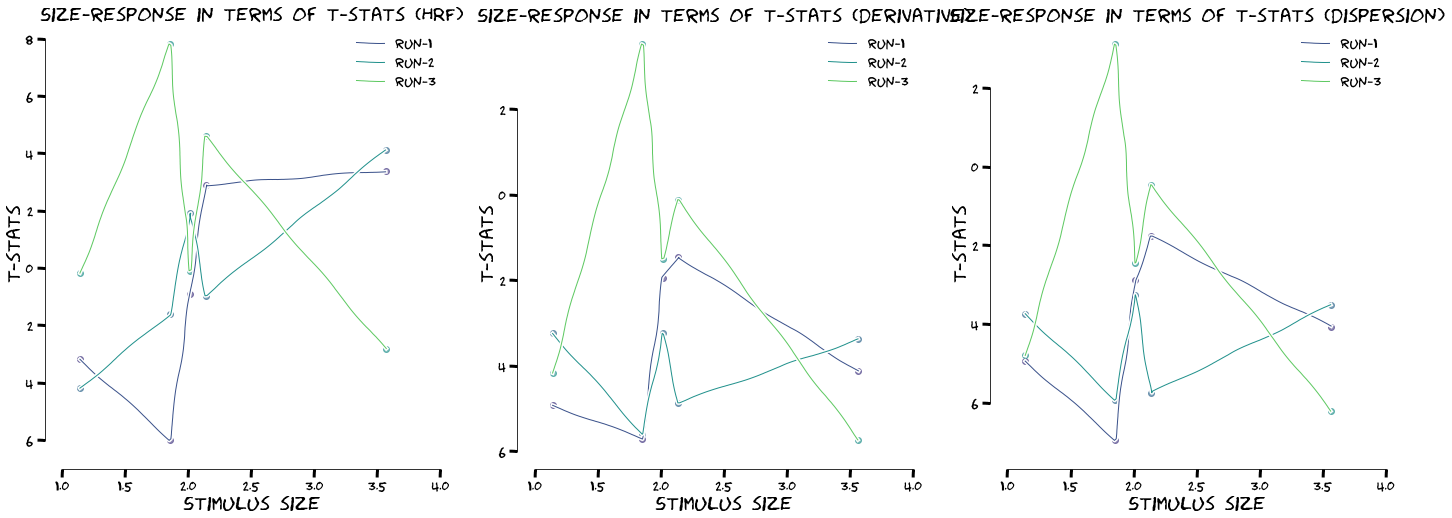

In [20]:
fig = plt.figure(figsize=(24,8))
gs = fig.add_gridspec(1,3)

x = [float(ii) for ii in fitting.condition_names]
color_list = sns.color_palette('viridis', len(x))

# plot the main HRF
for idx,hrf in enumerate(['HRF', 'derivative', 'dispersion']):

    ax1 = fig.add_subplot(gs[idx])

    if hrf == "HRF":
        sr_run = tstats[1::3,ribbon[0]:ribbon[1],...].mean(axis=1)
    elif hrf == "derivative":
        sr_run = tstats[2::3,ribbon[0]:ribbon[1],...].mean(axis=1)
    elif hrf == "dispersion":
        sr_run = tstats[3::3,ribbon[0]:ribbon[1],...].mean(axis=1)

    sr_ = [sr_run[...,ii] for ii in range(sr_run.shape[-1])]
    for ix, mark in enumerate(sr_):
        ax1.plot(x, mark, 'o', color=color_list[ix], alpha=0.6)

    plotting.LazyPlot(sr_,
                    xx=x,
                    axs=ax1, 
                    title=f"Size-response in terms of t-stats ({hrf})", 
                    font_size=20,
                    x_label="Stimulus size",
                    y_label="t-stats",
                    xkcd=plot_xkcd,
                    x_lim=[x[0]-0.2,x[-1]+0.5],
                    sns_trim=True,
                    labels=[f"run-{ii+1}" for ii in range(len(sr_run))])

# Old HRF (double-gamma, no derivatives)

In [11]:
fitters = []
tstats = np.zeros((6,720,3))
for run in range(3):
    data = utils.select_from_df(df_func, expression=(f"run = {runs[run]}"))
    onsets = utils.select_from_df(df_onsets, expression=(f"run = {runs[run]}"))

    fitting = glm.GenericGLM(onsets, data.values, TR=data_obj.TR, osf=1000, derivative=True, verbose=True)
    fitters.append(fitting)

    tstats[...,run] = fitting.results['tstats']

# calculate average tstats
avg_runs = tstats.mean(axis=-1)
print(avg_runs.shape)
avg_tstats = [avg_runs[ii+1,...] for ii in range(avg_runs.shape[0]-1)]

Creating stimulus vector(s)
Defining HRF
Convolve stimulus vectors with HRF
Resample convolved stimulus vectors
Creating design matrix
Running fit
max tstat (vox 545) = 6.91
max beta (vox 545) = 2.72
Creating stimulus vector(s)
Defining HRF
Convolve stimulus vectors with HRF
Resample convolved stimulus vectors
Creating design matrix
Running fit
max tstat (vox 540) = 14.16
max beta (vox 540) = 5.26
Creating stimulus vector(s)
Defining HRF
Convolve stimulus vectors with HRF
Resample convolved stimulus vectors
Creating design matrix
Running fit
max tstat (vox 627) = 8.0
max beta (vox 627) = 3.21
(6, 720)


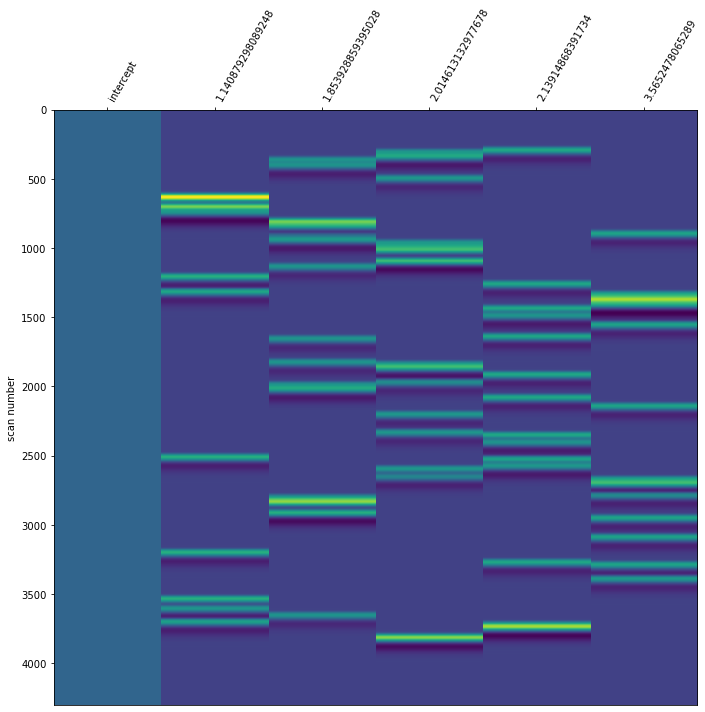

In [12]:
fitting.plot_design_matrix()

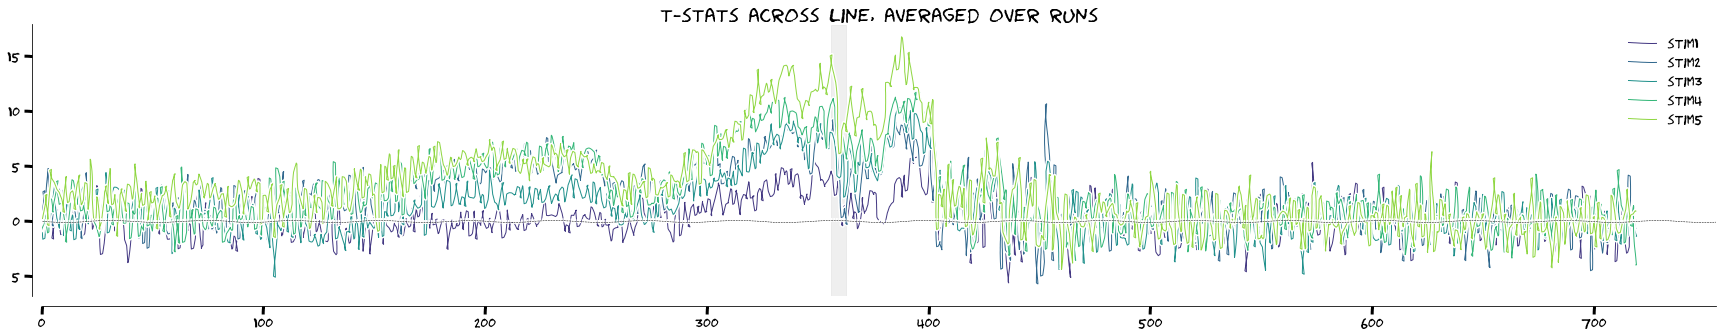

In [13]:
fig, axs = plt.subplots(figsize=(30,5))
axs.axvspan(*ribbon, alpha=0.3, color="#cccccc")
plotting.LazyPlot(avg_tstats,
                  axs=axs, 
                  add_hline='default', 
                  set_xlim_zero=True, 
                  sns_trim=False, 
                  title="t-stats across line, averaged over runs", 
                  font_size=20, 
                  xkcd=plot_xkcd,
                  labels=[f"stim{ii+1}" for ii in range(len(fitting.condition_names))])

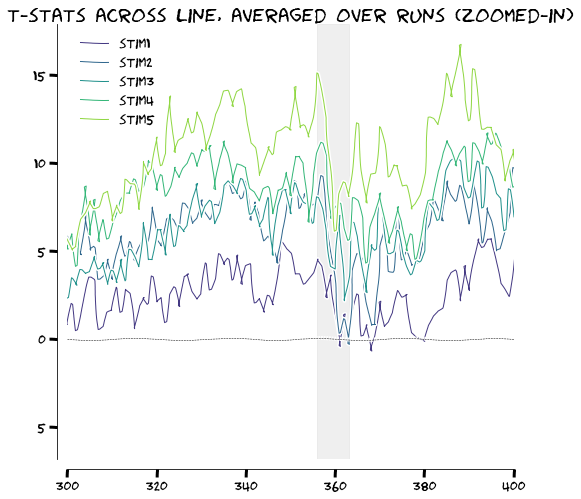

In [14]:
fig, axs = plt.subplots(figsize=(8,8))
axs.axvspan(*ribbon, alpha=0.3, color="#cccccc")
plotting.LazyPlot(avg_tstats,
                  axs=axs, 
                  add_hline='default', 
                  set_xlim_zero=False, 
                  sns_trim=False, 
                  title="t-stats across line, averaged over runs (zoomed-in)", 
                  font_size=20, 
                  x_lim=[300,400],
                  xkcd=plot_xkcd,
                  labels=[f"stim{ii+1}" for ii in range(len(fitting.condition_names))])

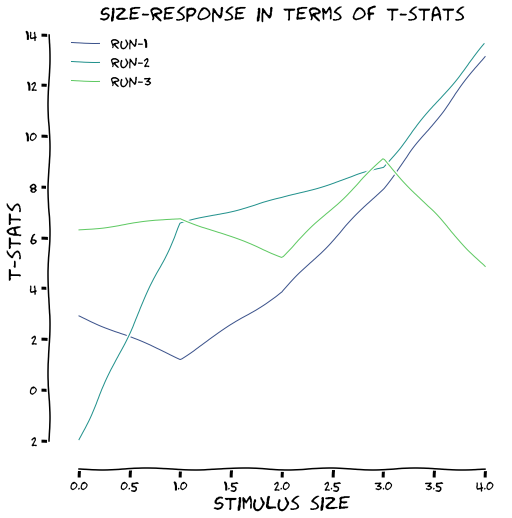

In [15]:
sr_run = tstats[1:,ribbon[0]:ribbon[1],...].mean(axis=1)
sr_ = [sr_run[...,ii] for ii in range(sr_run.shape[-1])]


plotting.LazyPlot(sr_,
                  figsize=(8,8), 
                  set_xlim_zero=False, 
                  sns_trim=True, 
                  title="Size-response in terms of t-stats", 
                  font_size=20,
                  x_label="Stimulus size",
                  y_label="t-stats",
                  xkcd=plot_xkcd,
                  labels=[f"run-{ii+1}" for ii in range(len(sr_run))])

The Gauss-Markov theorem states that in order for OLS to yield valid estimates (including estimates of the parameters’ standard errors) _the errors (residuals) have a mean of 0_, _have 0 covariance (i.e., are uncorrelated)_, and _have equal variance_ (source: https://lukas-snoek.com/NI-edu/fMRI-introduction/week_4/temporal_preprocessing.html#assumption-of-zero-mean-of-the-residuals).

In [16]:
for ix, fit in enumerate(fitters):
    mean_resids = fit.results['resids'].mean()
    print(f"Mean of residuals run-{ix+1}: %3.f" % mean_resids)

Mean of residuals run-1:   0
Mean of residuals run-2:  -0
Mean of residuals run-3:   0


So, let’s check visually whether the assumption of equal variance of our residuals roughly holds for our (simulated) fMRI data. Now, when we consider this assumption in the context of our fMRI data, the assumption of “equal variance of the residuals” (also called homoskedasticity) means that we assume that the “error” in the model is equally big across our timeseries data. In other words, the mis-modelling (error) should be constant over time.

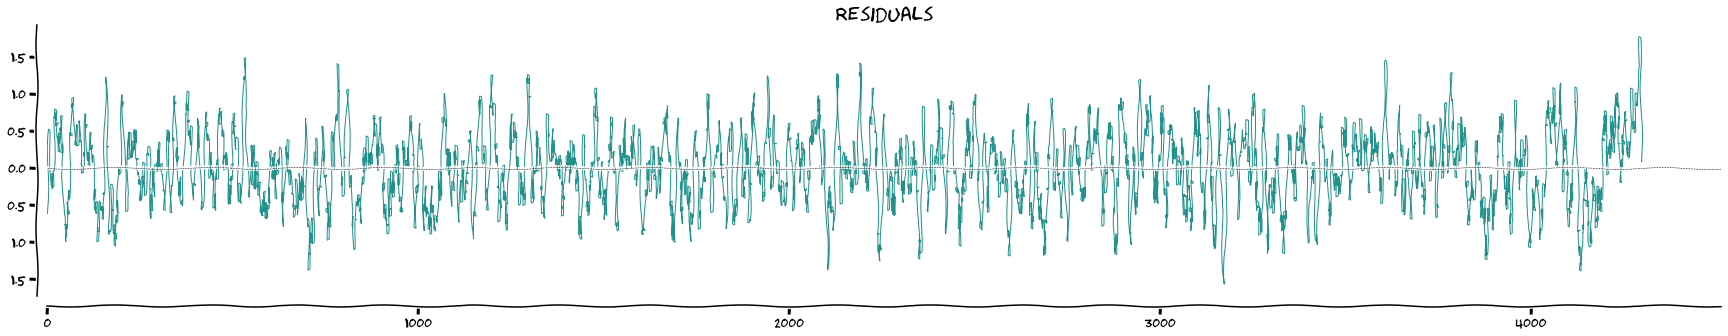

In [17]:
plotting.LazyPlot(fitting.results['resids'][:,359], 
                  figsize=(30,5), 
                  add_hline='default', 
                  set_xlim_zero=True, 
                  sns_trim=False, 
                  title="Residuals", 
                  xkcd=plot_xkcd,
                  font_size=20)

Looks quite alright! Sure, there is some variation here and there, but given that our estimates (including the residuals and their variance!) are imperfect, this suffices.

---
# Deconvolution

Select only the voxels from the cortical ribbon

In [54]:
df_ribbon = utils.select_from_df(df_func, expression='ribbon', indices=ribbon)
df_ribbon


vox 356   vox 357   vox 358   vox 359   vox 360  \
subject run t                                                           
003     3   0.000    1.057538  0.984256  0.813249 -0.552205 -0.725136   
            0.105   -0.431190 -1.012072 -0.483677 -0.046064  0.166930   
            0.210   -0.019410  0.635418  1.236497  0.366018 -0.605408   
            0.315    0.222330 -0.077449  0.649852 -0.840606  0.167011   
            0.420    1.835661  1.841457  0.702518  1.187170 -0.076877   
...                       ...       ...       ...       ...       ...   
        6   450.975 -0.026251  1.208908 -0.481812  0.466277 -0.860905   
            451.080  2.191127 -0.001526  2.024212  1.703386  1.506163   
            451.185 -1.249861  1.152682  0.830240 -0.351010 -0.011519   
            451.290  2.473472  0.045679  0.956825  1.641507  1.406834   
            451.395 -0.450189 -0.239324  0.503122  0.096395  0.888536   

                      vox 361   vox 362  
subject run t                            
003     3   0.000   -1.496149 -1.550875  
            0.105    0.326550  0.953220  
            0.210   -0.497072 -0.408029  
            0.315   -0.703388  0.334091  
            0.420    0.423634 -0.759376  
...                       ...       ...  
        6   450.975  1.326847  0.448608  
            451.080  0.532296 -0.079511  
            451.185  1.465793  0.225026  
            451.290 -0.070485  0.578939  
            451.395  0.825847  0.915068  

[13300 rows x 7 columns]

## Size-Response information

Here we fetch relevant pRF-parameters that are required to construct the size-response curve below (this is the same curve as in `derivatives/pycortex/<subject>/<subject>_hemi-?_desc-prf_sizeresponse.pdf`).

In [6]:
# # collect subject data including Normalization parameters
# subject_info = utils.CollectSubject(f"sub-{sub}", prf_dir=opj(deriv_dir, 'prf', f"sub-{sub}", 'ses-1'), cx_dir=opj(deriv_dir, 'pycortex', f"sub-{sub}"), settings='recent', hemi="lh", model="norm")

# # initiate the SizeResponse class
# SR = prf.SizeResponse(subject_info.prf_stim, subject_info.normalization_params, subject_info=subject_info)

# # make the stimuli
# SR.make_stimuli()

# # make the curve
# sr_curve1 = SR.make_sr_function(center_prf=True)

# # stimsizes are in SR.stims_fill_sizes

Perform the deconvolution using nideconv. For now, the physio-regressors are excluded because they look unreliable (see plot of heart rate above..). There might have been something wrong with the PPU/Resp acquisition, but best to leave them out until we have a run with good physiology

## Model: no differentation between stimulus size (Gamma functions)

First, we perform deconvolution with gamma basis sets

In [55]:
nd_gamma = utils.NideconvFitter(df_ribbon,
                                df_onsets,
                                confounds=None,
                                basis_sets='canonical_hrf_with_time_derivative',
                                n_regressors=None,
                                lump_events=False,
                                TR=0.105,
                                interval=[0, 12],
                                add_intercept=True,
                                verbose=True)


Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event '1.140879298089248' to model
Adding event '1.853928859395028' to model
Adding event '2.014613132977678' to model
Adding event '2.13914868391734' to model
Adding event '3.5652478065289' to model
Fitting with 'ols' minimization
Done


Plot 

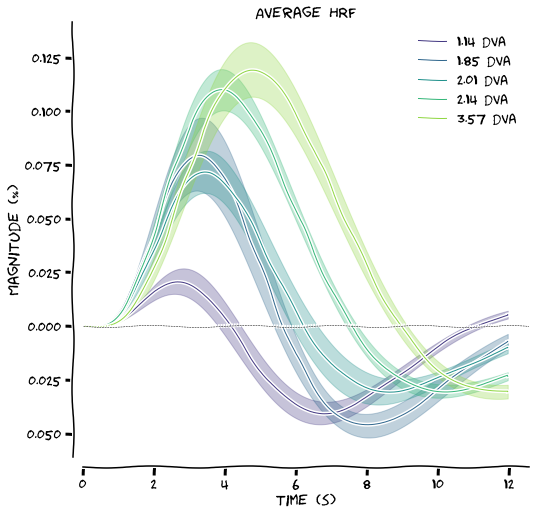

In [56]:
nd_gamma.plot_average_per_event(xkcd=True,
                                labels=[f"{round(float(ii),2)} dva" for ii in nd_gamma.cond],
                                alpha=0.2,
                                figsize=(8, 8),
                                x_label="time (s)",
                                y_label="Magnitude (%)",
                                add_hline='default')


## Model: no differentation between stimulus size

Next, we run a deconvolution without differentiation between stimulus sizes: all events are considered the same, so we should get 1 HRF out. Theoretically, this should already scale with cortical depth

In [59]:
lumped = utils.NideconvFitter(df_ribbon,
                              df_onsets,
                              confounds=None,
                              basis_sets='fourier',
                              n_regressors=11,
                              lump_events=True,
                              TR=0.105,
                              interval=[0,12],
                              add_intercept=True,
                              verbose=True,
                              fit_type='ols')

Selected 'fourier'-basis sets
Adding event 'stim' to model
Fitting with 'ols' minimization
Done


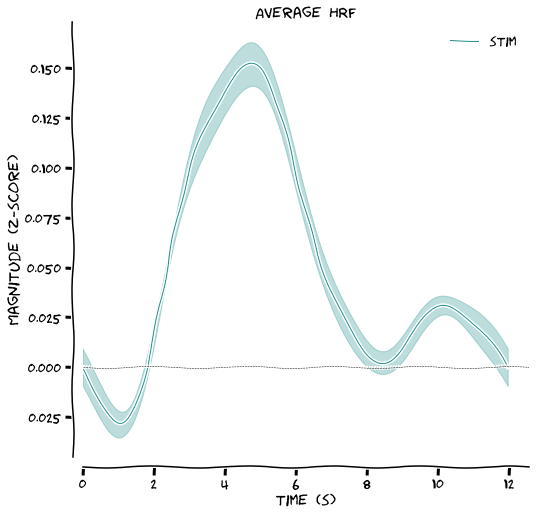

In [61]:
# plot average across 
lumped.plot_average_per_event(xkcd=plot_xkcd,
                              labels=['stim'],
                              figsize=(8, 8),
                              x_label="time (s)",
                              y_label="Magnitude (z-score)",
                              add_hline='default')


In [62]:
lumped.rsq_

vox 356   vox 357   vox 358   vox 359   vox 360   vox 361  \
subject run                                                               
003     3    0.015577  0.020298  0.014673  0.010332  0.006011  0.005889   
        4    0.011145  0.013431  0.009302  0.010504  0.005175  0.007142   
        6    0.012974  0.011648  0.012778  0.005509  0.006740  0.004015   

              vox 362  
subject run            
003     3    0.007871  
        4    0.004172  
        6    0.002290

With this lumped-event model, we can also plot the HRFs across depth, independent of stimulus size (left plot). We can then extract the maximums of all HRFs and fit a polynomial to it, revealing a trend towards decreased HRF-amplitude when going from CSF/GM to GM/WM borders

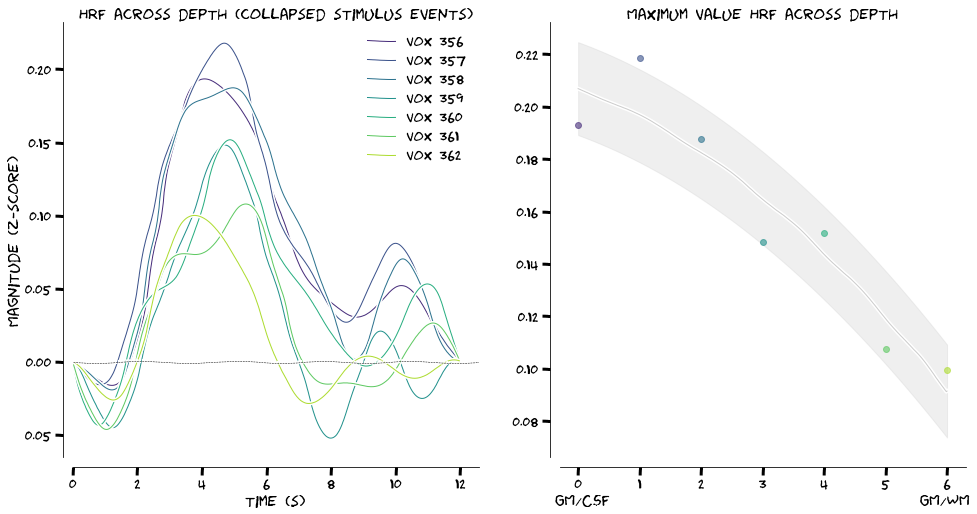

In [65]:
# plot individual voxels in 1 figure
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(1, 2)

ax = fig.add_subplot(gs[0])
lumped.plot_average_per_voxel(xkcd=plot_xkcd,
                              n_cols=None,
                              figsize=(8, 8),
                              axs=ax,
                              labels=True,
                              title="HRF across depth (collapsed stimulus events)",
                              x_label="time (s)",
                              y_label="Magnitude (z-score)",
                              add_hline='default')

ax = fig.add_subplot(gs[1])
lumped.plot_hrf_across_depth(xkcd=True,
                             axs=ax,
                             title="Maximum value HRF across depth",
                             x_label="GM/CSF                                        GM/WM",
                             set_xlim_zero=False)


## Model: each stimulus size = event (fourier)

In [69]:
nd_fit = utils.NideconvFitter(df_ribbon,
                              df_onsets,
                              confounds=None,
                              basis_sets='fourier',
                              n_regressors=9,
                              lump_events=False,
                              TR=0.105,
                              interval=[0, 12],
                              add_intercept=True,
                              verbose=True)


Selected 'fourier'-basis sets
Adding event '1.140879298089248' to model
Adding event '1.853928859395028' to model
Adding event '2.014613132977678' to model
Adding event '2.13914868391734' to model
Adding event '3.5652478065289' to model
Fitting with 'ols' minimization
Done


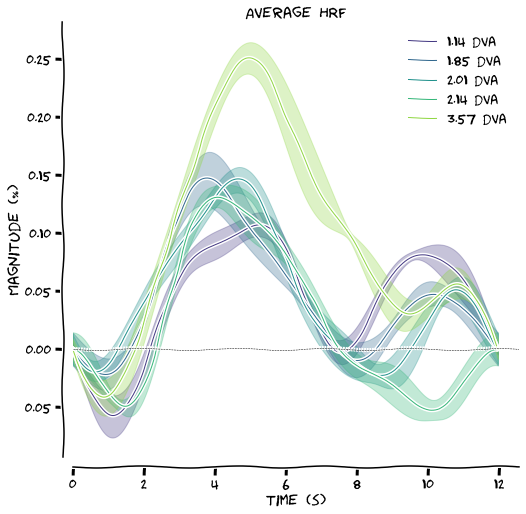

In [70]:
nd_fit.plot_average_per_event(xkcd=plot_xkcd,
                              labels=[
                                  f"{round(float(ii),2)} dva" for ii in nd_fit.cond],
                              alpha=0.2,
                              figsize=(8, 8),
                              x_label="time (s)",
                              y_label="Magnitude (%)",
                              add_hline='default')


Above we can see pretty decent HRF-responses in the left panel. We see that the largest stimulus size evokes the largest HRF with smaller stimulus sizes having lower HRF amplitudes. Despite that this is expected, I think it's still cool and promising. As for the SR-curve, we can see that the order is correct: smaller stimulus sizes = lower HRF. However, the normalized amplitudes are somewhat shifted compared to where we expected them to be based on the SR-curve. This is because of the way I normalized the maximums of the HRFs. See [this](https://github.com/spinoza-centre/pRFline/issues/4#issuecomment-1028001384) issue in the `pRFline`-repository.

Below I plotted the HRF for each voxel in the cortical ribbon in response to all stimulus sizes:

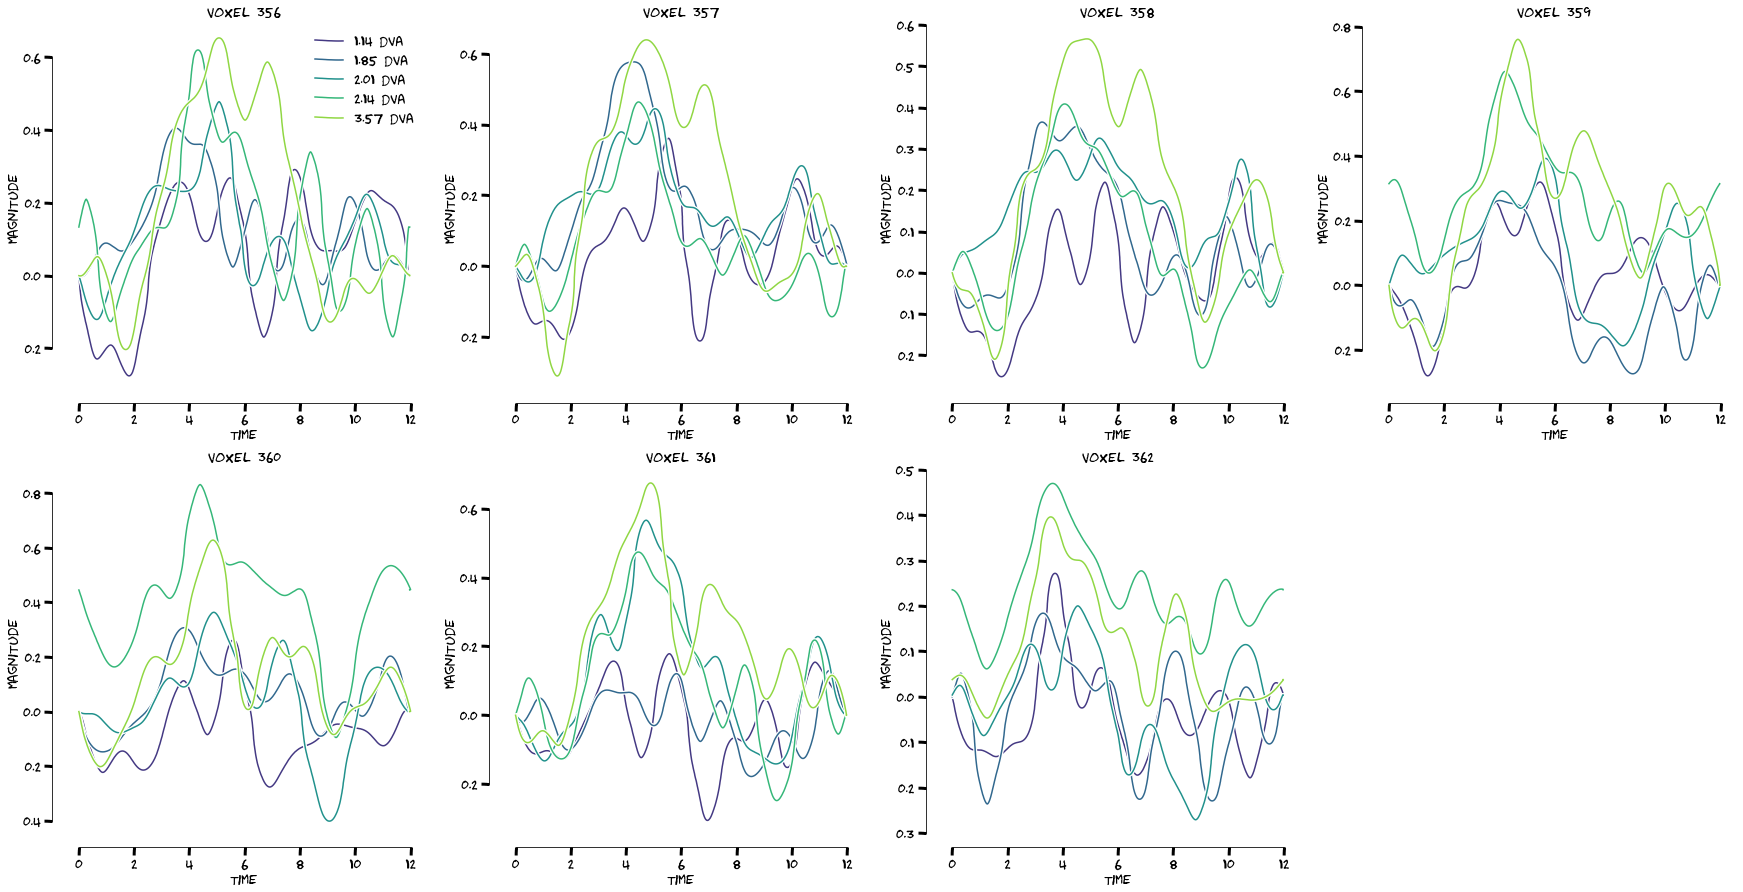

In [46]:
vox = np.arange(*ribbon)

fig = plt.figure(figsize=(30,15))
gs = fig.add_gridspec(2,(len(vox)//2)+1)
for ix,voxel in enumerate(vox):

    # fetch data from specific voxel for each stimulus size
    data = []
    for idc,size in enumerate(cond):
        vox_data = tc_condition[f'vox {voxel}'][size].values
        vox_data += vox_data[0]
        data.append(vox_data)

    # draw legend once
    if ix == 0:
        labels = [f"{round(float(ii),2)} dva" for ii in cond]
    else:
        labels = None
    
    # plot all stimulus sizes for a voxel
    ax = fig.add_subplot(gs[ix])
    plotting.LazyPlot(data,
                      xx=time_axis,
                      axs=ax,
                      x_label="time",
                      y_label="magnitude",
                      font_size=14,
                      title=f"voxel {voxel}",
                      line_width=1.5,
                      labels=labels,
                      xkcd=plot_xkcd)